# ⚠️ WARNING

The analysis here posed problems because the phi-psi method does not work well for clustering loops of different lengths...

# Introduction

Clustering CDR loops by $\phi$ and $\psi$ angles in apo and holo states. The goal is to see if cluster membership changes in these two groups.

In [1]:
import sys; sys.path.insert(0, '/home/b/bmcmaste/.local/lib/python3.11/site-packages/')

In [2]:
import os
import itertools
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.aligners import align_pandas_structure, align_sequences
from python_pdb.parsers import parse_pdb_to_pandas
from python_pdb.entities import Structure
from python_pdb.comparisons import rmsd
from python_pdb.formats.residue import THREE_TO_ONE_CODE
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [3]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-pmhc-interface-analysis/data/apo-holo-mhc-class-I_refined_aligned'

In [4]:
def calculate_angle(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    
    cos_theta = np.dot(v1, v2) / (n1 * n2)
    
    cos_theta = min(cos_theta, 1)
    cos_theta = max(cos_theta, -1)
    
    return np.arccos(cos_theta)

def calculate_dihedral_angle(a, b, c, d):
    ba = a - b
    bc = c - b
    cd = d - c
    
    u = np.cross(ba, bc)
    v = np.cross(cd, bc)
    
    w = np.cross(u, v)
    
    angle = calculate_angle(u, v)
    
    if calculate_angle(bc, w) > 0.001:
        angle = -angle

    return angle

def calculate_phi_psi_angles(residue: pd.DataFrame, prev_residue: pd.DataFrame, next_residue: pd.DataFrame) -> tuple[float, float]:
    '''Calculate the dihedral (phi and psi) angles for a given residue.'''
    c_prev_pos = prev_residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    n_pos = residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    ca_pos = residue.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    c_pos = residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]

    n_next_pos = next_residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    phi_angle = calculate_dihedral_angle(c_prev_pos, n_pos, ca_pos, c_pos)
    psi_angle = calculate_dihedral_angle(n_pos, ca_pos, c_pos, n_next_pos)
    
    return (phi_angle, psi_angle)

In [5]:
def find_anchors(cdr_df, structure_df):
    cdr_start = cdr_df.iloc[0].name
    cdr_end = cdr_df.iloc[-1].name

    start_anchor_info = structure_df.loc[:cdr_start].tail(1).iloc[0][['chain_id', 'residue_seq_id', 'residue_insert_code']]
    end_anchor_info = structure_df.loc[cdr_end:].head(2).iloc[1][['chain_id', 'residue_seq_id', 'residue_insert_code']]

    if start_anchor_info['residue_insert_code']:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code == @start_anchor_info.residue_insert_code'))

    else:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code.isnull()'))

    if end_anchor_info['residue_insert_code']:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code == @end_anchor_info.residue_insert_code'))

    else:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code.isnull()'))
    
    return start_anchor, end_anchor

In [6]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

In [7]:
def align_tcrs(tcr_mobile_df, tcr_target_df):            
    mobile_coords = []
    target_coords = []
        
    for chain_type in ('alpha_chain', 'beta_chain'):
        fw_chain_sequences = []
        fw_chain_ca_coords = []
        
        for df in (tcr_mobile_df, tcr_target_df):
            fw_chain = df.query('cdr.isnull() and residue_seq_id < 128 and chain_type == @chain_type')
            
            fw_chain_ca_coords.append(fw_chain.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].values)
            
            fw_chain_seq = fw_chain.drop_duplicates(['residue_seq_id', 'residue_insert_code'])['residue_name'].map(lambda tlc: THREE_TO_ONE_CODE[tlc]).tolist()
            fw_chain_sequences.append(fw_chain_seq)
        
        fw_chain_seq_alignment, _ = align_sequences(*fw_chain_sequences)
        

        iter_mobile_ca_coords = iter(fw_chain_ca_coords[0])
        iter_target_ca_coords = iter(fw_chain_ca_coords[1])

        for res_id_mobile, res_id_target in fw_chain_seq_alignment:
            next_res_ca_coords_mobile = next(iter_mobile_ca_coords) if res_id_mobile != '-' else None
            next_res_ca_coords_target = next(iter_target_ca_coords) if res_id_target != '-' else None

            if next_res_ca_coords_mobile is not None and next_res_ca_coords_target is not None:
                mobile_coords.append(next_res_ca_coords_mobile)
                target_coords.append(next_res_ca_coords_target)

    mobile_coords = np.array(mobile_coords)
    target_coords = np.array(target_coords)

    return align_pandas_structure(mobile_coords, target_coords, tcr_mobile_df)

In [8]:
# Info
group_names = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []

# Measurements
apo_phis = []
apo_psis = []
holo_phis = []
holo_psis = []

for group in (dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))):
    print(group)
    
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        state1 = path1.split('.')[0].split('_')[-1]
        state2 = path2.split('.')[0].split('_')[-1]

        # Skip holo-holo and apo-apo comparisons for now
        if state1 == state2:
            continue

        if state1 == 'apo':
            apo_path = path1
            holo_path = path2
        else:
            apo_path = path2
            holo_path = path1
        
        chains_apo = get_chain_assignments(apo_path)
        chains_holo = get_chain_assignments(holo_path)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, apo_path), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        with open(os.path.join(DATA_DIR, group, holo_path), 'r') as fh:
            holo_df = parse_pdb_to_pandas(fh.read())
        
        # Annotate records
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: chains_apo[chain_id])
        holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: chains_holo[chain_id])
        
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        apo_tcr_df = align_tcrs(apo_tcr_df, holo_tcr_df)
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            apo_cdr = apo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            holo_cdr = holo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            
            # add anchors to cdr loops
            apo_start_anchor, apo_end_anchor = find_anchors(apo_cdr, apo_tcr_df)
            apo_cdr = pd.concat([apo_start_anchor, apo_cdr, apo_end_anchor])
            
            holo_start_anchor, holo_end_anchor = find_anchors(holo_cdr, holo_tcr_df)
            holo_cdr = pd.concat([holo_start_anchor, holo_cdr, holo_end_anchor])
            
            # Group Residues
            group_apo = apo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group_holo = holo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            groups = list(zip(group_apo, group_holo))
            num_residues = len(groups)
            
            cdr_res_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            cdr_apo_phis = []
            cdr_apo_psis = []
            
            cdr_holo_phis = []
            cdr_holo_psis = []
            
            for i, (((res_name, seq_id, insert_code), res1), (_, res2)) in enumerate(groups):
                if i == 0 or i == num_residues - 1:  # ignore anchor residues
                    continue
                
                prev_res_1 = groups[i - 1][0][-1]
                next_res_1 = groups[i + 1][0][-1]
                
                prev_res_2 = groups[i - 1][1][-1]
                next_res_2 = groups[i + 1][1][-1]
                
                phi_1, psi_1 = calculate_phi_psi_angles(res1, prev_res_1, next_res_1)
                phi_2, psi_2 = calculate_phi_psi_angles(res2, prev_res_2, next_res_2)
                
                cdr_res_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)
            
                cdr_apo_phis.append(phi_1)
                cdr_apo_psis.append(psi_1)
            
                cdr_holo_phis.append(phi_2)
                cdr_holo_psis.append(psi_2)
            
            num_residues = len(cdr_res_names)
            
            residue_names += cdr_res_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            apo_phis += cdr_apo_phis
            apo_psis += cdr_apo_psis
            
            holo_phis += cdr_holo_phis
            holo_psis += cdr_holo_psis
            
            group_names += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues
            
results_phi_psi = pd.DataFrame({
    'group': group_names,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'apo_phi': apo_phis,
    'apo_psi': apo_psis,
    'holo_phi': holo_phis,
    'holo_psi': holo_psis,
})

YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGAGGADTQY
7n1c_DE_apo.pdb 7n1e_DECA_holo.pdb
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQEGDTQY
6at6_AB_apo.pdb 6avf_ABPH_holo.pdb
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY
3vxt_AB_apo.pdb 3vxu_DECA_holo.pdb
3vxt_AB_apo.pdb 3w0w_DECA_holo.pdb
3vxu_DECA_holo.pdb 3w0w_DECA_holo.pdb
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
6vth_DE_apo.pdb 6vrm_DEPA_holo.pdb
YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY
1g6r_ABPH_holo.pdb 2ckb_CDQI_holo.pdb
1g6r_ABPH_holo.pdb 1mwa_ABPH_holo.pdb
1g6r_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1g6r_ABPH_holo.pdb 1tcr_AB_apo.pdb
2ckb_CDQI_holo.pdb 1mwa_ABPH_holo.pdb
2ckb_CDQI_holo.pdb 2oi9_BCQA_holo.pdb
2ckb_CDQI_holo.pdb 1tcr_AB_apo.pdb
1mwa_ABPH_holo.pdb 2oi9_BCQA_holo.pdb
1mwa_ABPH_holo.pdb 1tcr_AB_apo.pdb
2oi9_BCQA_holo.pdb 1tcr_AB_apo.pdb
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY
5nmf_DECA_holo.pdb 5nmd_AB_apo.pdb
5nmf_DECA_holo.pdb 5nmg_DECA_holo.pdb
5nmf_DECA_holo.pdb 5nme_IJHF_holo.p

In [9]:
results_phi_psi

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,apo_phi,apo_psi,holo_phi,holo_psi
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,0.657484,-1.403569,0.649607,-1.197001
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,LEU,39,NaN,3.052959,-0.252866,-2.913306,0.304167
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,0.615772,2.690121,0.597253,-1.499119
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,-0.481142,1.299756,-0.426278,0.266987
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,-1.010428,0.969414,-1.623102,0.719126
...,...,...,...,...,...,...,...,...,...,...,...,...
2292,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,SER,107,NaN,-2.564233,-2.202147,-2.821265,-1.862122
2293,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,-1.510407,1.096030,-1.670193,1.296774
2294,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,2.297896,-0.746786,1.868005,-0.748214
2295,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,-2.514997,-1.123420,-2.121907,-1.252825


In [14]:
results_phi_psi['apo_phi_deg'] = results_phi_psi['apo_phi'].apply(np.degrees)
results_phi_psi['apo_psi_deg'] = results_phi_psi['apo_psi'].apply(np.degrees)
results_phi_psi['holo_phi_deg'] = results_phi_psi['holo_phi'].apply(np.degrees)
results_phi_psi['holo_psi_deg'] = results_phi_psi['holo_psi'].apply(np.degrees)

In [15]:
results_phi_psi['resi'] = results_phi_psi['residue_seq_id'].apply(str) + results_phi_psi['residue_insert_code'].fillna('')

# Test on CDR-A1 first

In [16]:
apo_df = results_phi_psi.melt(id_vars=['group',
                              'struct1', 'struct2',
                              'cdr',
                              'chain_type',
                              'residue_name', 'residue_seq_id', 'residue_insert_code', 'resi'],
                     value_vars=['apo_phi_deg', 'apo_psi_deg'],
                     var_name='angle_type',
                     value_name='angle')
apo_df['angle_type'] = apo_df['angle_type'].map(lambda name: name.split('_')[1])

holo_df = results_phi_psi.melt(id_vars=['group',
                                        'struct1', 'struct2',
                                        'cdr',
                                        'chain_type',
                                        'residue_name', 'residue_seq_id', 'residue_insert_code', 'resi'],
                     value_vars=['holo_phi_deg', 'holo_psi_deg'],
                     var_name='angle_type',
                     value_name='angle')
holo_df['angle_type'] = holo_df['angle_type'].map(lambda name: name.split('_')[1])


angles = apo_df.merge(holo_df, on=['group',
                                   'struct1', 'struct2',
                                   'cdr',
                                   'chain_type',
                                   'residue_name', 'residue_seq_id', 'residue_insert_code', 'resi',
                                   'angle_type'], suffixes=('_apo', '_holo'))

angles

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,resi,angle_type,angle_apo,angle_holo
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,29,phi,37.671066,37.219732
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,LEU,39,NaN,39,phi,174.921675,-166.920141
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,37,phi,35.281161,34.220060
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,28,phi,-27.567395,-24.423911
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,36,phi,-57.893280,-92.996878
...,...,...,...,...,...,...,...,...,...,...,...,...
4589,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,SER,107,NaN,107,psi,-126.173753,-106.691731
4590,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,110,psi,62.797915,74.299686
4591,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,117,psi,-42.787667,-42.869519
4592,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,108,psi,-64.367222,-71.781607


In [17]:
angles['angle_position'] = angles['resi'] + ' ' + angles['angle_type']

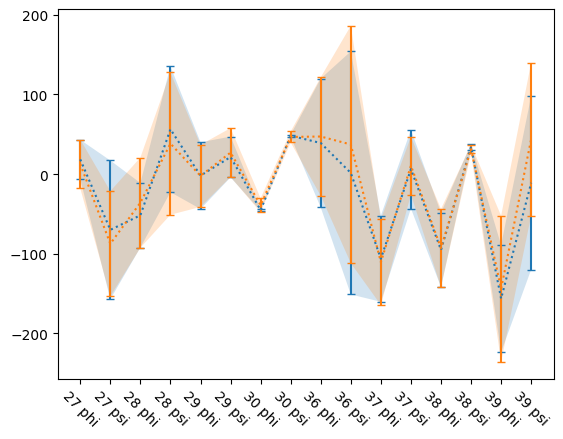

In [18]:
cdr1_alpha_angles = angles.query("chain_type == 'alpha_chain' and cdr == 1")

cdr1_alpha_angles = cdr1_alpha_angles.sort_values('angle_position')

data = cdr1_alpha_angles.groupby('angle_position').agg({'angle_apo': ['mean', 'std'], 'angle_holo': ['mean', 'std']})

plt.errorbar(data.index, data['angle_apo']['mean'], data['angle_apo']['std'],
             alpha=1, fmt=':', capsize=3, capthick=1)

plt.fill_between(data.index, data['angle_apo']['mean'] - data['angle_apo']['std'], data['angle_apo']['mean'] + data['angle_apo']['std'],
             alpha=.2)

plt.errorbar(data.index, data['angle_holo']['mean'], data['angle_holo']['std'],
             alpha=1, fmt=':', capsize=3, capthick=1)

plt.fill_between(data.index, data['angle_holo']['mean'] - data['angle_holo']['std'], data['angle_holo']['mean'] + data['angle_holo']['std'],
             alpha=.2)

plt.xticks(rotation=-45)
print()

In [19]:
cdr1_alpha_loop_data = cdr1_alpha_angles.pivot(index=['group', 'struct1', 'struct2'], columns='angle_position', values='angle_apo')
cdr1_alpha_loop_data

angle_position                                                                               27 phi  \
group                                              struct1            struct2                         
DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF  3qdj_DECA_holo.pdb 3qeu_DE_apo.pdb    -12.469283   
                                                   3qeu_DE_apo.pdb    3qdg_DECA_holo.pdb -12.469283   
                                                   6am5_DECA_holo.pdb 3qeu_DE_apo.pdb    -12.469283   
                                                   6amu_DECA_holo.pdb 3qeu_DE_apo.pdb    -12.469283   
DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY     7n1f_DECA_holo.pdb 7n1d_AB_apo.pdb     -5.563397   
                                                   7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb     -5.563397   
DRGSQS-IYSNGD-AVRTNSGYALN-QGHDT-YYEEEE-ASSDTVSYEQY 5nmd_AB_apo.pdb    5nme_IJHF_holo.pdb  -4.619201   
                                                                      5nmg_DECA_holo.pdb  -4.619201   
                                                   5nmf_DECA_holo.pdb 5nmd_AB_apo.pdb     -4.619201   
DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLAG... 1qse_DECA_holo.pdb 7amp_AB_apo.pdb      8.569525   
                                                   3d3v_DECA_holo.pdb 7amp_AB_apo.pdb      8.569525   
                                                   3pwp_DECA_holo.pdb 7amp_AB_apo.pdb      8.569525   
                                                   7amp_AB_apo.pdb    1ao7_DECA_holo.pdb   8.569525   
                                                                      1qrn_DECA_holo.pdb   8.569525   
                                                                      1qsf_DECA_holo.pdb   8.569525   
                                                                      3d39_DECA_holo.pdb   8.569525   
                                                                      3h9s_DECA_holo.pdb   8.569525   
                                                                      3qfj_DECA_holo.pdb   8.569525   
DRGSQS-IYSNGD-GTYNQGGKLI-MNHEY-SMNVEV-ASSGASHEQY   3vxt_AB_apo.pdb    3vxu_DECA_holo.pdb  -4.907246   
                                                                      3w0w_DECA_holo.pdb  -4.907246   
DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTG... 7r7z_AB_apo.pdb    7r80_ABEC_holo.pdb  44.338016   
DSAIYN-IQSSQRE-AVRMDSSYKLI-SEHNR-FQNEAQ-ASSSWDT... 3vxq_DE_apo.pdb    3vxr_DECA_holo.pdb  33.467670   
                                                                      3vxs_DECA_holo.pdb  33.467670   
DSAIYN-IQSSQRE-AVRPLLDGTYIPT-MNHEY-SVGAGT-ASSYL... 2pyf_AB_apo.pdb    2pye_DECA_holo.pdb  38.287851   
DSAIYN-IQSSQRE-AVRPTSGGSYIPT-MNHEY-SVGAGI-ASSYV... 2bnu_AB_apo.pdb    2bnq_DECA_holo.pdb  38.670381   
                                                                      2bnr_DECA_holo.pdb  38.670381   
                                                                      2f54_DECA_holo.pdb  38.670381   
                                                                      6q3s_DECA_holo.pdb  38.670381   
FLGSQS-TYREGD-AVNDGGRLT-GTSNPN-WGPFG-AWSETGLGMGGWQ 4jfd_DECA_holo.pdb 4jfh_DE_apo.pdb     -3.173500   
                                                   4jfe_DECA_holo.pdb 4jfh_DE_apo.pdb     -3.173500   
                                                   4jff_DECA_holo.pdb 4jfh_DE_apo.pdb     -3.173500   
                                                   6eqb_DECA_holo.pdb 4jfh_DE_apo.pdb     -3.173500   
                                                   6tmo_DECA_holo.pdb 4jfh_DE_apo.pdb     -3.173500   
NIATNDY-GYKTK-LVGEILDNFNKFY-MDHEN-SYDVKM-ASSQRQ... 6at6_AB_apo.pdb    6avf_ABPH_holo.pdb -19.744597   
NSAFDY-ILSVSNK-AASASFGDNSKLI-MSHET-SYDVDS-ASSLG... 5ivx_EFPA_holo.pdb 5iw1_AB_apo.pdb     40.108733   
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKL... 3utp_DE_apo.pdb    3uts_DECA_holo.pdb  40.375379   
                                                                      5c07_DECA_holo.p

In [21]:
import umap

umap.__version__

'0.5.5'

In [23]:
embeddings = umap.UMAP().fit_transform(cdr1_alpha_loop_data.values, force_all_finite='allow-nan')

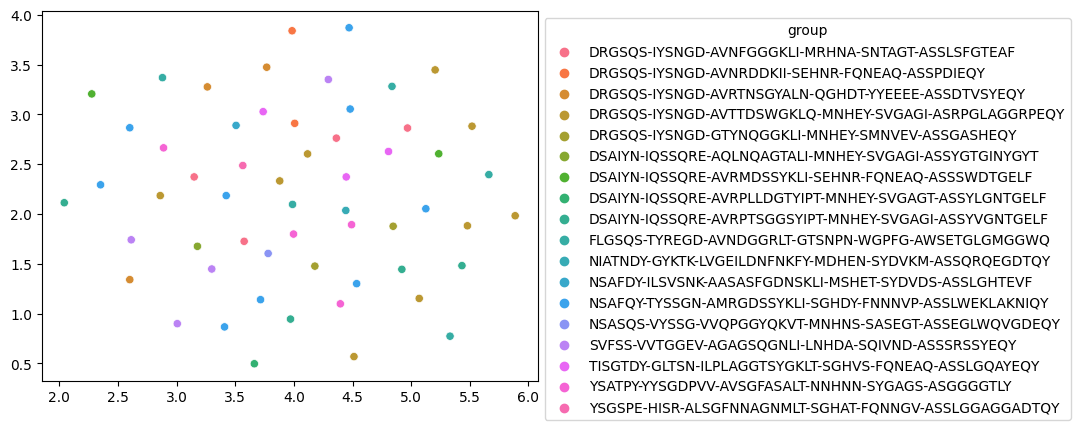

In [35]:
ax = sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=cdr1_alpha_loop_data.reset_index()['group'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

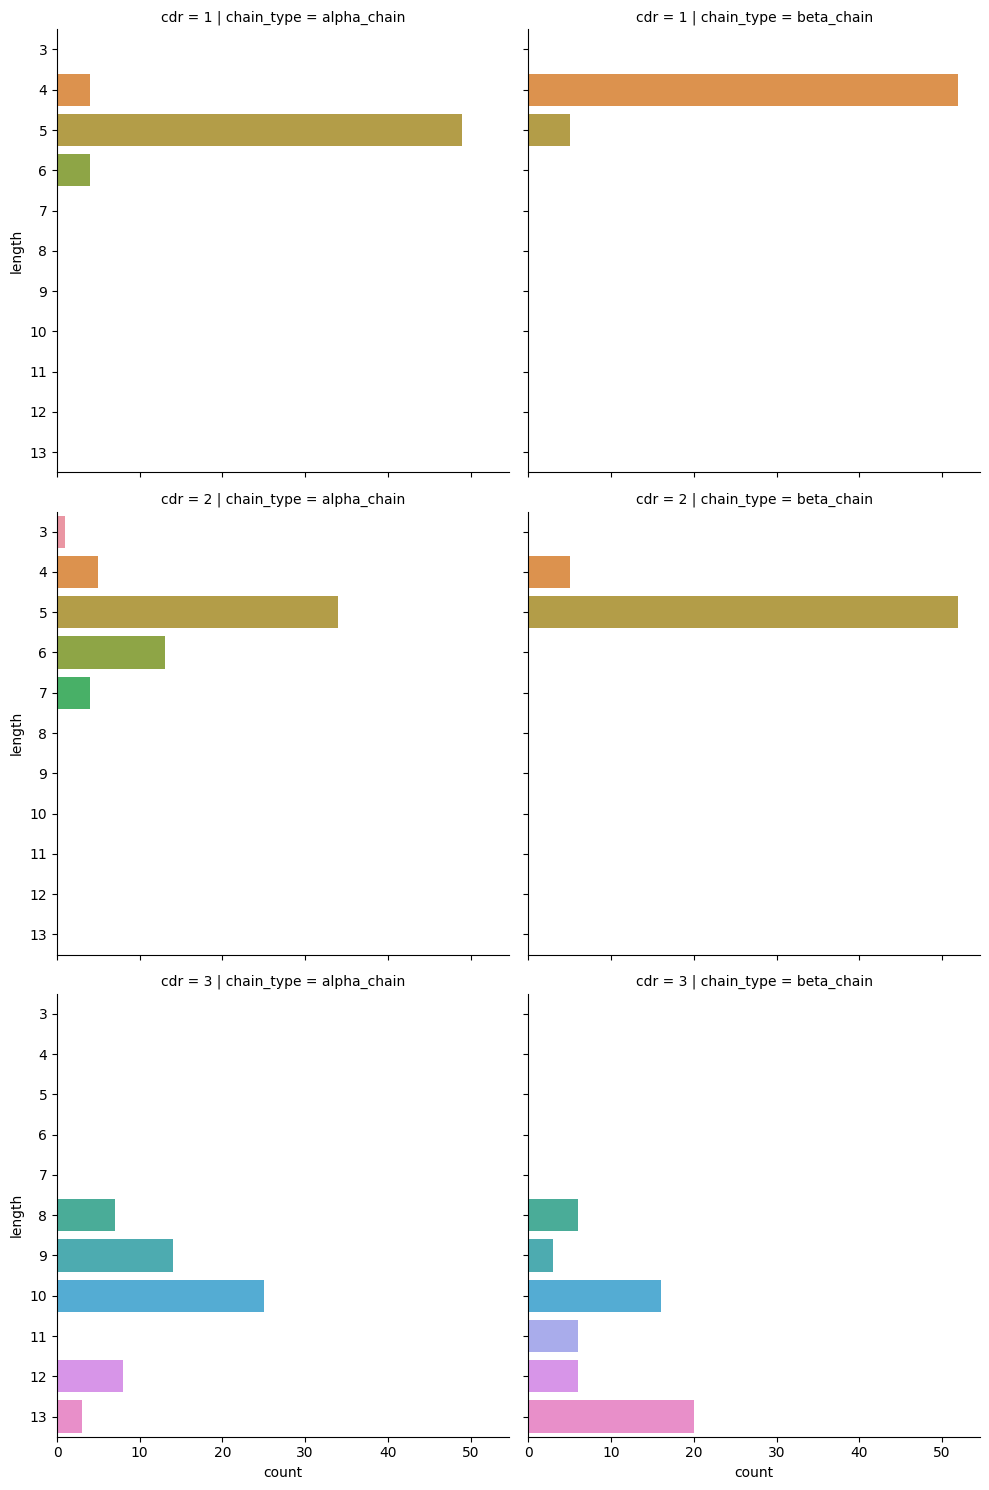

In [54]:
loop_lengths = results_phi_psi.groupby(['group', 'cdr', 'chain_type', 'struct1', 'struct2']).size()
loop_lengths.name = 'length'

loop_lengths = loop_lengths.reset_index()
sns.catplot(loop_lengths, y='length', row='cdr', col='chain_type', kind='count', orient='v')

In [51]:
results_phi_psi

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,apo_phi,apo_psi,holo_phi,holo_psi,resi,apo_phi_deg,apo_psi_deg,holo_phi_deg,holo_psi_deg
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,0.657484,-1.403569,0.649607,-1.197001,29,37.671066,-80.418592,37.219732,-68.583104
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,LEU,39,NaN,3.052959,-0.252866,-2.913306,0.304167,39,174.921675,-14.488168,-166.920141,17.427458
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,0.615772,2.690121,0.597253,-1.499119,37,35.281161,154.132574,34.220060,-85.893213
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,-0.481142,1.299756,-0.426278,0.266987,28,-27.567395,74.470533,-24.423911,15.297210
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,-1.010428,0.969414,-1.623102,0.719126,36,-57.893280,55.543340,-92.996878,41.202885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,SER,107,NaN,-2.564233,-2.202147,-2.821265,-1.862122,107,-146.919742,-126.173753,-161.646558,-106.691731
2293,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,-1.510407,1.096030,-1.670193,1.296774,110,-86.539955,62.797915,-95.695014,74.299686
2294,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,2.297896,-0.746786,1.868005,-0.748214,117,131.659739,-42.787667,107.028827,-42.869519
2295,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,-2.514997,-1.123420,-2.121907,-1.252825,108,-144.098701,-64.367222,-121.576293,-71.781607
